# Online Sports Betting: Beating the Bookie

#### Notebook created by Steven Newton (Github: https://github.com/konstanzer/online-sports-betting)
---

Kaunitz, Zhong & Kreiner, the authors of **Beating the bookies with their own numbers - and how the online sports betting market is rigged (2017)**, introduced me to a novel and brilliant approach to sports betting. Rather than compete with the bookmakers predictions,the authors show how to beat the bookmakers by using their predictions against them. They demonstrate how to take advantage of mispriced odds using the implicit information in bookmakers' aggregate odds. Bookmakers countered the authors success by limiting the size and type of bets they were allowed to place, leading to the second conclusion of the paper: any bettor who finds a consistently profitable strategy will encounteer discriminatory practices at the hands of betting exchanges.

Paper: https://www.researchgate.net/publication/320296375_Beating_the_bookies_with_their_own_numbers_-_and_how_the_online_sports_betting_market_is_rigged

Blog: https://www.lisandrokaunitz.com/index.php/en/category/beatthebookies-en/

### Summary 

I set out to create a value betting algorithm for this project but the paper linked to above convinced me it would be a lesson in futility. Strategies based on team and player attributes are very unlikely to compete successfully with the models bookmakers' use when setting the odds. Aggregating many bookmakers' odds, however, can tell a bettor when an individual bookmaker is offering mispriced odds. Furthermore, a strategy that exploits these opportunities repeatedly can significantly outperform random betting in the long-term. In this notebook, I create such a model using soccer match data while following closely Kreiners's method closely.

### Agenda

1. [Data](#data)
  - Data dictionary
  - Data description
2.  [Exploration](#explore)
  - What are the odds?
  - Evaluating the bookmakers' odds
3.  [Building a Winning Strategy](#model)
  - Mispriced odds model
  - Random betting strategy
4.  [Results](#results)
  - Matrics
  - Next steps

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scipy.stats as scs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')

The prepared dataset in the form of csv files is available for download at https://www.kaggle.com/austro/beat-the-bookie-worldwide-football-dataset

In [135]:
#Matches with odds data.
PATH = '/content/drive/MyDrive/Colab Notebooks/data/'
close = pd.read_csv(PATH + 'closing_odds.csv', index_col=0)

<a name='data'></a>
## 1. Data

---

### 1.1 Data dictionary

| Feature       | Description    |
|---------------|----------------|
| 'league'      |  pro soccer league |
| 'match_date'  |  match date        |
| 'home_team'   |  home team         |
| 'home_score'  |  home team goals scored    |
| 'away_team'   |  away team                 |
| 'away_score'  |  away team goals scored    |
| 'avg_odds_home_win'   |  average odds for bet on home team win at game start      |
| 'max_odds_home_win'   |  best odds for bet on home team win at game start |
| 'top_bookie_home_win' | bookmaker offering max odds                 |
| 'n_odds_home_win'     | number of bookmakers providing odds for bet |

**Home win** data repeats for **away win** and **draw** (not shown), the other two possible outcomes of a soccer match.


### 1.2 Dataset description

Kaunitz, et al. collected historical closing odds (i.e. odds provided at game-time) for 479,440 soccer matches between 2005 and 2015 from 32 online bookmakers. The hard part of scraping the data off bookies' websites and cleaning it has been done for me.

"closing_odds.csv". The csv file is a matrix of games (rows) x features (teams, scores, league, etc).


A full list of the bookmakers

---
Interwetten https://www.interwetten.com/en/sportsbook, bwin https://sports.bwin.com/en/sports, bet-at-home https://www.bet-at-home.com/en/sport, Unibet https://www.bet-at-home.com/en/sport, Stan James http://stanjames-betting.com/, Expekt https://www.expekt.com/en-fi, 10Bet https://www.10bet.com/sports/, William Hill https://www.williamhill.com/, bet365 https://www.nj.bet365.com/#/HO/, Pinnacle Sports https://www.pinnacle.com/en/, DOXXbet https://m.doxxbet.com.lr/ui/#/, Betsafe https://www.betsafe.com/en, Betway https://betway.com/en/sports, 888sport https://www.888sport.com, Ladbrokes https://sports.ladbrokes.com/, Betclic https://www.betclic.com/en/sports-betting/, Sportingbet https://sports.sportingbet.com/en/sports, myBet , Betsson, 188BET, Jetbull, Paddy Power, Tipico, Coral, SBOBET, BetVictor, 12BET, Titanbet, Youwin, ComeOn, Betadonis, Betfair

<a name='explore'></a>
## 2. Exploration

---

### 2.1 What are the odds?

In [4]:
close.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 479440 entries, 170088 to 876812
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   league               479440 non-null  object 
 1   match_date           479440 non-null  object 
 2   home_team            479440 non-null  object 
 3   home_score           479440 non-null  int64  
 4   away_team            479440 non-null  object 
 5   away_score           479440 non-null  int64  
 6   avg_odds_home_win    479440 non-null  float64
 7   avg_odds_draw        479440 non-null  float64
 8   avg_odds_away_win    479440 non-null  float64
 9   max_odds_home_win    479440 non-null  float64
 10  max_odds_draw        479440 non-null  float64
 11  max_odds_away_win    479440 non-null  float64
 12  top_bookie_home_win  479412 non-null  object 
 13  top_bookie_draw      479440 non-null  object 
 14  top_bookie_away_win  479416 non-null  object 
 15  n_odds_home_

In [5]:
close.head(3)

,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,max_odds_home_win,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win
match_id,,,,,,,,,,,,,,,,,,
170088,England: Premier League,2005-01-01,Liverpool,0,Chelsea,1,2.9944,3.1944,2.2256,3.20,3.25,2.29,Paddy Power,Sportingbet,Expekt,9,9,9
170089,England: Premier League,2005-01-01,Fulham,3,Crystal Palace,1,1.9456,3.2333,3.6722,2.04,3.30,4.15,Pinnacle Sports,bet-at-home,Expekt,9,9,9
170090,England: Premier League,2005-01-01,Aston Villa,1,Blackburn,0,1.8522,3.2611,4.0144,2.00,3.40,4.50,Pinnacle Sports,Paddy Power,Sportingbet,9,9,9


Here I am interested in seeing who is frequently offering the best odds.

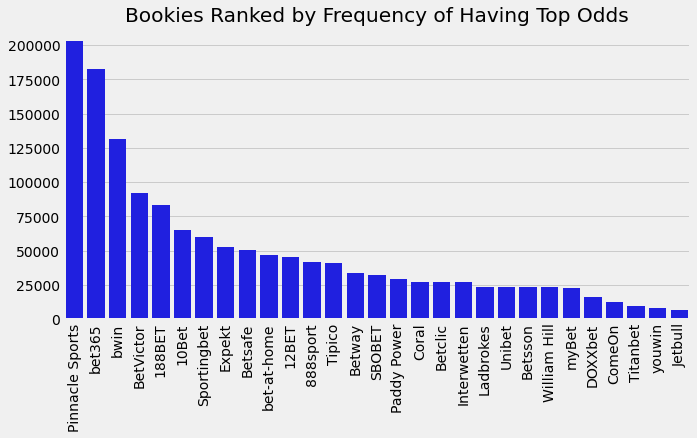

In [26]:
top_bookie = (close.top_bookie_home_win.value_counts() + close.top_bookie_away_win.value_counts()
                + close.top_bookie_draw.value_counts()).sort_values(ascending=False)
sns.barplot(top_bookie.index, top_bookie.values, color='blue')
plt.title('Bookies Ranked by Frequency of Having Top Odds')
plt.xticks(rotation=90)
plt.show()

I'll convert odds of a home win, away win, or draw to probability for each of the matches.  The consensus probability is the mean of all odds for each outcome and for each match 

$P = 1 / mean(odds)$

In [7]:
#prob. rounded to nearest 1/80th
bins = 80
close['avg_prob_home_win'] = np.floor((1/close['avg_odds_home_win'])*bins)/bins
close['avg_prob_away_win'] = np.floor((1/close['avg_odds_away_win'])*bins)/bins
close['avg_prob_draw'] = np.floor((1/close['avg_odds_draw'])*bins)/bins

All odds are right-skewed. Home-wins are more likely than away-wins. Away-wins have more variance. Notice that odds represent what the bettor receives if she wins a 1 unit bet, which means the odds cannot be less than 1. Mean odds restated as ratios would be:
* Home-win: 1.5:1
* Away-win: 2:1
* Draw: 2.7:1

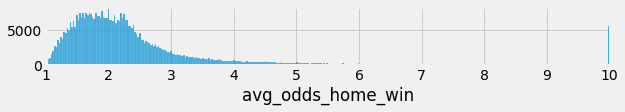

   mean: 2.52
   st. dev.: 1.94


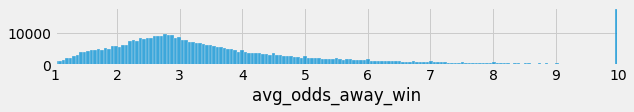

   mean: 3.97
   st. dev.: 2.79


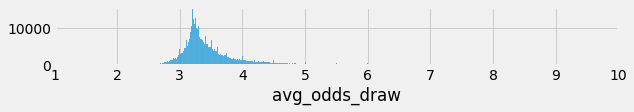

   mean: 3.67
   st. dev.: 1.07


In [8]:
for odds in ['avg_odds_home_win', 'avg_odds_away_win', 'avg_odds_draw']:
    plt.figure(figsize=(9,1))
    sns.histplot(close[odds].clip(0,10)) #there are some really high odds
    plt.ylabel('')
    plt.xlim(1,10)
    plt.show()
    print(f'   mean: {round(close[odds].mean(),2)}')
    print(f'   st. dev.: {round(close[odds].std(),2)}')

### 2.2 Evaluating the bookmakers' odds

A strategy intended to beat the bookmakers at predicting the game outcome (value betting, the commonest form of algorithmic betting) requires a more accurate model than the ones bookmakers have developed.

The mean accuracy in the prediction of the outcome is the proportion of games ending in home team victory, draw, or away team victory for each probability bin. Kaunitz, et al. figured out that the **consensus probability is a good estimate of the underlying probability of an outcome**. There's not much room for improvement if I want to build a value betting algorithm.

In [9]:
#create dummy variables for home win, away win, or draw
close['home_win'] = close.home_score > close.away_score
close['away_win'] = close.home_score < close.away_score
close['draw'] = close.home_score == close.away_score
#and a categorical variable
close['result'] = close.home_win + 2*close.away_win + 3*close.draw

#calculate the accuracy for each predicted probability for each outcome
home_win_acc = close.groupby('avg_prob_home_win').mean()['home_win']
away_win_acc = close.groupby('avg_prob_away_win').mean()['away_win']
draw_acc = close.groupby('avg_prob_draw').mean()['draw']

#retain accuracy if there are a min. of observations
min_obs = 100
home_win_acc = home_win_acc[close.groupby('avg_prob_home_win').sum()['home_win']>min_obs]
away_win_acc = away_win_acc[close.groupby('avg_prob_away_win').sum()['away_win']>min_obs]
draw_acc = draw_acc[close.groupby('avg_prob_draw').sum()['draw']>min_obs]

close = close.drop(columns=['avg_prob_home_win','avg_prob_away_win',
                            'avg_prob_draw','home_win','away_win','draw'])

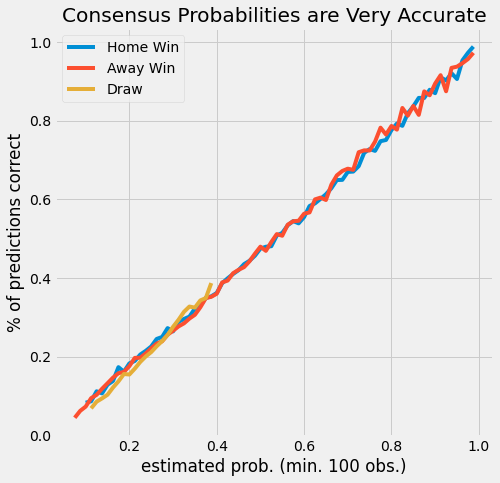

In [136]:
plt.figure(figsize=(7,7))
plt.plot(home_win_acc)
plt.plot(away_win_acc)
plt.title("Consensus Probabilities are Very Accurate")
plt.xlabel(f"estimated prob. (min. {min_obs} obs.)")
plt.ylabel("% of predictions correct")
plt.plot(draw_acc)
plt.legend(['Home Win','Away Win','Draw'])
plt.savefig(PATH + 'cons_prob.png')
plt.show()

#### Correlation and Linear Regression

Linear regression shows a strong correlation between the consensus probability and the outcome of the game.

In [11]:
X1, y1 = np.array(home_win_acc.index), home_win_acc.values
X2, y2 = np.array(away_win_acc.index), away_win_acc.values
X3, y3 = np.array(draw_acc.index), draw_acc.values

#usage note: Pearson is most appropriate for measurements taken from an interval scale
print(f'Home win correlation w/ consensus prob.: {scs.pearsonr(X1, y1)[0]}')
print(f'Away win correlation w/ consensus prob.: {scs.pearsonr(X2, y2)[0]}')
print(f'Draw correlation w/ consensus prob.: {scs.pearsonr(X3, y3)[0]}')

lr_home = LinearRegression().fit(X1.reshape(-1,1), y1)
print(f'\nHome win R^2: {lr_home.score(X1.reshape(-1,1), y1)}')
print(f'  Slope: {lr_home.coef_[0]}')
print(f'  Intercept: {lr_home.intercept_}')

lr_away = LinearRegression().fit(X2.reshape(-1,1), y2)
print(f'\nAway win R^2: {lr_away.score(X2.reshape(-1,1), y2)}')
print(f'  Slope: {lr_away.coef_[0]}')
print(f'  Intercept: {lr_away.intercept_}')

lr_draw = LinearRegression().fit(X3.reshape(-1,1), y3)
print(f'\nDraw R^2: {lr_draw.score(X3.reshape(-1,1), y3)}')
print(f'  Slope: {lr_draw.coef_[0]}')
print(f'  Intercept: {lr_draw.intercept_}')

Home win correlation w/ consensus prob.: 0.9991602101754098
Away win correlation w/ consensus prob.: 0.9989934449323413
Draw correlation w/ consensus prob.: 0.9973540095619423

Home win R^2: 0.9983211255977693
  Slope: 1.0034599516781513
  Intercept: -0.027983375901089125

Away win R^2: 0.9979879030177871
  Slope: 1.0143944298317413
  Intercept: -0.0330748929189012

Draw R^2: 0.9947150203892826
  Slope: 1.1241387885615723
  Intercept: -0.06254265835427109


Deducing the high accuracy of the bookmakers' aggregated odds is significant because it tells me the difficulties I would face building a value betting algorithm, which is the typical approach to algorithmic sports betting.

<a name='model'></a>
## 3. Building a Winning Strategy

---

### 3.1 Mispriced odds model

I'll implement Kaunitz, Zhong, and Kreiner's strategy. This is explained in depth in their paper.

The optimal strategy maximizes **expected payoff**, which looks like this.

$E(X) = (p-α)*Ω - 1$

  where $X$ is a random variable representing the payoff of the bet,

  where $Ω$ are the odds paid by the bookmaker

  where $p$ is the underlying probability of the outcome

  and where $α$ is an adjustment term to account for the bookies' commission. The regression intercepts are the estimated $α$ while the final value is found through trial-and-error. Why intercepts? Because we would expect the regression line to pass through the origin (0, 0) if there wasn't a commission.

I should bet when $E(X) > 0$.

Therefore, rearranging for odds, the betting condition is,

$Ω > 1 / (p - α) $

Notice that increasing $α$ increases the expected value while decreasing the number of available bets (because the margins are higher.) To keep things simple, bets will all be of the same size (50 dollars) for this simulation.


In [107]:
alpha = .05 #adjustment term
min_odds = 4 #minimum bookmakers offering odds
bet = 50 #bet size for every bet

The max odds represent the best available odds on that bet among all the bookmakers so that'll be used to calculate payoff while average odds are used for exact probabilities. Ensure at least 4 bookmakers have given odds for the bet so the market isn't too thin.

Aside: Don't accidently use binned probability data here, which would also not need the numerator. I made this mistake and it cost me a day of frustration.

In [13]:
def exp_payoff(res):
  return ((1 / close[f'avg_odds_{res}'] - alpha)\
          * close[f'max_odds_{res}'] - 1)\
          * (close[f'n_odds_{res}'] > min_odds)

exp_payouts = pd.DataFrame({'exp_payoff0': exp_payoff('home_win'),
                            'exp_payoff1': exp_payoff('away_win'),
                            'exp_payoff2': exp_payoff('draw')})

#highest payout per match
max_exp_payout = np.max(exp_payouts, axis=1)
#one-indexed column of highest payout
max_column = 1+np.argmax(np.array(exp_payouts), axis=1)

bets = []
for ix, i in enumerate(max_column):
  #place bet if max exp. value is positive
  if max_exp_payout.values[ix] > 0:
    bets.append(i)
  else:
    bets.append(0)

close['bet_result'] = bets

#validation check
sum(close.bet_result>0) == sum(max_exp_payout>0)

True

In [14]:
#create a list of relevant max odds based on game result
maximums = close.iloc[:,[9,11,10]] #order rearranged to match result column
max_odds = []
for i, j in zip(maximums.values, close.result):
  max_odds.append(i[j-1])

close['max_odds'] = max_odds

In [15]:
bet_df = close.iloc[:,18:21][close.bet_result > 0]
n_bets = len(bet_df)
bet_df['win'] = bet_df.bet_result == bet_df.result
bet_df['payoff'] = bet_df.win * bet_df.max_odds - 1
bet_df['gain'] = bet_df.payoff * bet
bet_df['cumulative'] = bet + bet_df.gain.cumsum()
             
bet_df.head()

,result,bet_result,max_odds,win,payoff,gain,cumulative
match_id,,,,,,,
170112,1,1,1.74,True,0.74,37.0,87.0
170235,2,2,2.70,True,1.70,85.0,172.0
170236,2,1,3.50,False,-1.00,-50.0,122.0
170366,1,1,4.33,True,3.33,166.5,288.5
170382,3,1,3.00,False,-1.00,-50.0,238.5


In [43]:
mdl_accuracy = round(sum(bet_df.win)/n_bets,3)
print(f'Matches bet on: {n_bets} ({round(n_bets/len(close)*100,1)} percent)')
print(f'Accuracy of bets: {mdl_accuracy}')


Matches bet on: 55804 (11.6 percent)
Accuracy of bets: 0.443


In [45]:
mdl_profit = bet_df.cumulative.iloc[-1]
f'Profit of {mdl_profit} dollars generated on historical data.'

'Profit of 97481.0 dollars generated on historical data.'

### 3.2 Random bet strategy (baseline)

I randomly choose an equivalent number of games to bet on from the whole dataset and bet home win, away win, or draw based on prior probability of those outcomes.

In [33]:
#priors
prior_home = sum(bet_df.result==1)/n_bets #.44
prior_away = sum(bet_df.result==2)/n_bets #.31
prior_draw = sum(bet_df.result==3)/n_bets #.25

#generate probabilities then assign a result
guess = np.random.rand(len(bet_df))
guess[(1-prior_draw) < guess] = 3 #draw
guess[guess < prior_home] = 1 #home win
guess[(0 < guess) & (guess < 1)] = 2 #away win

prior_home, prior_away, prior_draw

(0.4378001576947889, 0.30884882804100067, 0.2533510142642105)

Bootstrapped samples have almost no variance, suggesting performance over the baseline cannot be due to random chance.

In [42]:
#bootstrapping simulations
trials = 10
accuracy = []

for _ in range(trials):
  idx = np.random.choice(len(close), len(bet_df))
  samp = close.iloc[idx].sort_index()
  samp['win'] = guess == samp.result
  samp['payoff'] = samp.win * samp.max_odds - 1
  samp['gain'] = samp.payoff * bet
  samp['cumulative'] = bet + samp.gain.cumsum()
  accuracy.append(sum(samp.win) / len(guess))

accuracy = np.array(accuracy)
bl_accuracy = round(accuracy.mean(),3)
print(f'Mean betting accuracy {bl_accuracy} and variance {round(accuracy.var(),4)}')
accuracy

Mean betting accuracy 0.353 and variance 0.0


array([0.354204  , 0.35336177, 0.35545839, 0.35337969, 0.35079923,
       0.35515375, 0.35180274, 0.35210738, 0.35155186, 0.35441904])

In [48]:
bl_profit = samp.cumulative.iloc[-1]
f'Loss of {-bl_profit} dollars on historical data.'

'Loss of 129265.5 dollars on historical data.'

In [73]:
results = pd.DataFrame({'betting accuracy': [mdl_accuracy, bl_accuracy,
                                             mdl_accuracy-bl_accuracy],
                        'bets placed': [n_bets, n_bets, 0],
                        'bet size': [bet, bet, 0],
                        'mean return on bet': [mdl_profit/n_bets, bl_profit/n_bets,
                                               mdl_profit/n_bets-bl_profit/n_bets],
                        'change in dollars': [mdl_profit, bl_profit,
                                              mdl_profit-bl_profit]},
                       index=['mispriced odds model',
                              'random model using priors (baseline)', 'difference'])

<a name='results'></a>
## 4. Results

---

### 4.1 Metrics

In the final comparison, the strategy which identifies mispriced odds *significantly* outperforms a random betting strategy.

In [74]:
results

,betting accuracy,bets placed,bet size,mean return on bet,change in dollars
mispriced odds model,0.443,55804,50,1.746846,97481.0
random model using priors (baseline),0.353,55804,50,-2.316420,-129265.5
difference,0.090,0,0,4.063266,226746.5


### 4.2 Charts

The difference between using the odds model and random betting is the difference between wealth and insolvency.

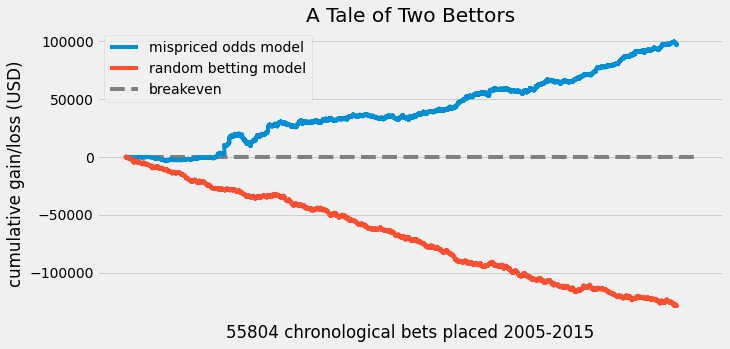

In [138]:
plt.plot(bet_df.cumulative)
plt.plot(samp.cumulative)
plt.hlines(0, 2e5, 9e5, color='gray', linestyles='dashed')
plt.ylabel('cumulative gain/loss (USD)')
plt.xlabel(f'{n_bets} chronological bets placed 2005-2015')
plt.title('A Tale of Two Bettors')
plt.legend(['mispriced odds model','random betting model', 'breakeven'])
plt.xticks([])
plt.savefig(PATH + 'two_bettors.png')
plt.show()

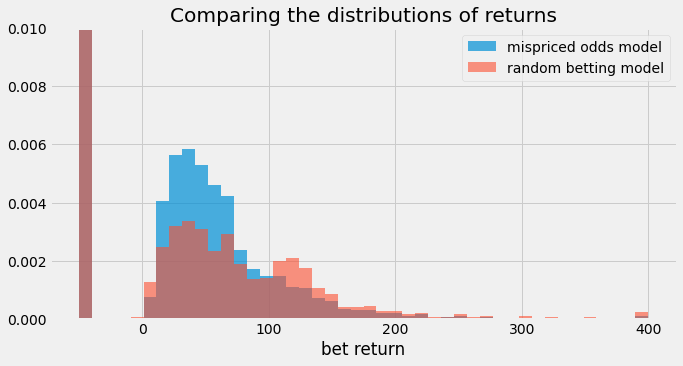

In [133]:
#there are some huge gains I should look at
plt.hist(bet_df.gain.clip(-bet,400), alpha=.7, bins=44, density=True)
plt.hist(samp.gain.clip(-bet,400), alpha=.6, bins=44, density=True)
plt.title('Comparing the distributions of returns')
plt.xlabel('bet return')
plt.ylim(0,.01) #huge spike at -50
plt.legend(['mispriced odds model','random betting model'])
plt.show()


In [106]:
#Welch's t-test on returns on bets
res = scs.ttest_ind(bet_df.gain, samp.gain, equal_var=False)
print(f'p-value: {res[1]} (probability of attaining these results randomly)')

p-value: 1.7324016163592228e-18 (probability of attaining these results randomly)


#### Next Steps

* Implement a 'continuous odds' strategy using real-time data.
* Achieve success with paper (live simulated) trading and then finally real trading
* Create a live dashboard to alert bettor of picks.